
# Toronto Housing distribution map

This notebook will show the distribution of houses for sale in each neighborhood in Toronto. And will also count the total facilities in each neighborhood. 

## Import Data

In [160]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
import geopandas as gpd
%pip install folium
import folium
from shapely.geometry import Point
from shapely import wkt

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 


Note: you may need to restart the kernel to use updated packages.


Let's add similiar nearby feature together into one CSV file

In [163]:
# restaurant
cafe = pd.read_csv('toronto-cafe.csv') 
restruarents = pd.read_csv('toronto__Pubs and restuarents.csv')
fastfood = pd.read_csv('toronto-fast_food.csv')
combined_csv = pd.concat([cafe, restruarents, fastfood ], axis=0, ignore_index=True)
combined_csv.to_csv('combined_resturants.csv', index=False)

# Public Service
hospital = pd.read_csv('toronto-Hospitals.csv') 
park = pd.read_csv('toronto-parks.csv') 
school = pd.read_csv('toronto-schools_uni_buildings.csv') 
combined_csv2 = pd.concat([hospital, park, school ], axis=0, ignore_index=True)
combined_csv2.to_csv('combined_Public Service.csv', index=False)

# Public Transit
bus = pd.read_csv('toronto_Bus Stations and Bus Stops.csv') 
rail = pd.read_csv('toronto__Railway Stations and  Railway Stops.csv') 
combined_csv3 = pd.concat([bus, rail ], axis=0, ignore_index=True)
combined_csv3.to_csv('combined_Public transit.csv', index=False)

# Other dailylife
kindergardens =  pd.read_csv('toronto-kindergartens.csv')
malls= pd.read_csv('toronto-malls.csv')
post_office= pd.read_csv('toronto-post_office.csv')
dental= pd.read_csv('toronto-dentist.csv')
supermarket =  pd.read_csv('toronto__Supermarkets.csv')
combined_csv4 = pd.concat([kindergardens, post_office, dental, supermarket ], axis=0, ignore_index=True)
combined_csv4.to_csv('combined_Other dailylife.csv', index=False)


In [165]:
neighbourhoods = gpd.read_file('Neighbourhoods - 4326 1.geojson') 

restruarent = pd.read_csv('combined_resturants.csv')
public_service = pd.read_csv('combined_Public Service.csv')
public_transit = pd.read_csv('combined_Public transit.csv')
other = pd.read_csv('combined_Other dailylife.csv')


toronto_1500 = pd.read_csv('Toronto_Houses_Facilities_1.5km.csv')
toronto_1000 = pd.read_csv('Toronto_Houses_Facilities_1km.csv')
toronto_500 = pd.read_csv('Toronto_Houses_Facilities_0.5km.csv')

house_data = pd.read_csv('housing_tor_clean_with_best_buffers_v2.3.csv')


neighbourhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"MULTIPOLYGON (((-79.386 43.698, -79.386 43.698..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"MULTIPOLYGON (((-79.397 43.707, -79.398 43.707..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"MULTIPOLYGON (((-79.434 43.66, -79.435 43.66, ..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"MULTIPOLYGON (((-79.439 43.668, -79.438 43.667..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"MULTIPOLYGON (((-79.384 43.645, -79.385 43.645..."


Let's add neighborhood geometry to the dataset to calculate the area of each neighborhood. By dividing the number of houses for sale that we scraped from the real estate website by the neighborhood area, we can determine the housing density in each neighborhood. This will give us some insight into the limitations of our model.

In [168]:
# Drop all columns except for 'geometry', and 'FIELD_8'
neighbourhoods = neighbourhoods[['geometry', 'AREA_NAME']] 
# Rename
neighbourhoods = neighbourhoods.rename(columns={'AREA_NAME': 'neighbourhood'})
# Split the name column at '(' and only keep the name
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.split('(').str[0] 
# Remove any leading or trailing spaces and lower case the neighbourhood
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.strip() 
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.lower()

neighbourhoods.head()

,geometry,neighbourhood
0,"MULTIPOLYGON (((-79.386 43.698, -79.386 43.698...",south eglinton-davisville
1,"MULTIPOLYGON (((-79.397 43.707, -79.398 43.707...",north toronto
2,"MULTIPOLYGON (((-79.434 43.66, -79.435 43.66, ...",dovercourt village
3,"MULTIPOLYGON (((-79.439 43.668, -79.438 43.667...",junction-wallace emerson
4,"MULTIPOLYGON (((-79.384 43.645, -79.385 43.645...",yonge-bay corridor


In [170]:
# Transform neighbourhoods to EPSG:26917
neighbourhoods = neighbourhoods.to_crs(epsg=26917)

# Calculate the area in square kilometers
neighbourhoods['area'] = neighbourhoods.geometry.area / 1e6  # Convert from square meters to square kilometers

# View GeoDataFrame
neighbourhoods.head()

,geometry,neighbourhood,area
0,"MULTIPOLYGON (((6.3e+05 4.84e+06, 6.3e+05 4.84...",south eglinton-davisville,0.944308
1,"MULTIPOLYGON (((6.29e+05 4.84e+06, 6.29e+05 4....",north toronto,0.402030
2,"MULTIPOLYGON (((6.26e+05 4.84e+06, 6.26e+05 4....",dovercourt village,1.503000
3,"MULTIPOLYGON (((6.26e+05 4.84e+06, 6.26e+05 4....",junction-wallace emerson,2.222863
4,"MULTIPOLYGON (((6.3e+05 4.83e+06, 6.3e+05 4.83...",yonge-bay corridor,1.118723


In [172]:
# House
# Convert to 4326
house_gdf = gpd.GeoDataFrame(
    house_data,
    geometry=gpd.points_from_xy(house_data['longitude'], house_data['latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
house_gdf = house_gdf.to_crs(epsg=26917)


# Restaurants
restruarents_gdf = gpd.GeoDataFrame(
    restruarent,
    geometry=gpd.points_from_xy(restruarent['Longitude'], restruarent['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
restruarents_gdf= restruarents_gdf.to_crs(epsg=26917)

# Public Service
public_service_gdf = gpd.GeoDataFrame(
    public_service,
    geometry=gpd.points_from_xy(public_service['Longitude'], public_service['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
public_service_gdf= public_service_gdf.to_crs(epsg=26917)

# Public Transit
public_transit_gdf = gpd.GeoDataFrame(
    public_transit,
    geometry=gpd.points_from_xy(public_transit['Longitude'], public_transit['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
public_transit_gdf= public_transit_gdf.to_crs(epsg=26917)

#Other
other_gdf = gpd.GeoDataFrame(
    other,
    geometry=gpd.points_from_xy(other['Longitude'], other['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
other_gdf= other_gdf.to_crs(epsg=26917)

house_data.head()


,neighbourhood,unnamed: 0,street address,latitude,longitude,geometry,price,bedrooms,bathrooms,total_crimes (2020-2024),...,bus stop_best_buffer_area_1.5_values,pub_best_buffer_area_0.5_values,restaurant_best_buffer_area_1.5_values,cafe_best_buffer_area_1.5_values,dentist_best_buffer_area_0.5_values,fast food_best_buffer_area_0.5_values,kindergartens_best_buffer_area_0.5_values,malls_best_buffer_area_0.5_values,play ground_best_buffer_area_0.5_values,post office_best_buffer_area_0.5_values
0,agincourt north,639,435 middlefield rd #56,43.808839,-79.256579,point (-79.256579 43.808839),848800,4,4,1285,...,45,0,7,1,0,0,0,0,0,0
1,agincourt north,755,78 ashridge dr,43.815736,-79.268628,point (-79.268628 43.815736),998000,5,3,1285,...,76,0,7,0,0,0,0,0,0,0
2,agincourt north,873,48 ardgowan cres,43.812243,-79.271403,point (-79.271403 43.812243),898000,4,3,1285,...,67,0,7,0,0,0,0,0,0,0
3,agincourt north,1082,119 - 5235 finch ave e,43.809932,-79.254877,point (-79.254877 43.809932),560000,3,2,1285,...,50,0,5,1,0,0,0,0,0,0
4,agincourt south malvern west,477,60 manorglen cres,43.780125,-79.271026,point (-79.271026 43.780125),1199000,4,3,1806,...,64,0,22,12,0,0,0,0,0,0


In [174]:
# Add new column that represents House, restaurants, public service , public transit and other in each neighbourhoods
neighbourhoods['house_counts'] = neighbourhoods.apply(lambda row: house_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['house_counts'] = neighbourhoods.apply(lambda row: house_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['restruarent_counts'] = neighbourhoods.apply(lambda row: restruarents_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['public_service_counts'] = neighbourhoods.apply(lambda row: public_service_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['public_transit_counts'] = neighbourhoods.apply(lambda row: public_transit_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['other_counts'] = neighbourhoods.apply(lambda row: other_gdf.within(row.geometry).sum(),axis = 1)
# sort value with descending order
neighbourhoods = neighbourhoods.sort_values('house_counts', ascending = False)
neighbourhoods['house_density'] = neighbourhoods['house_counts'] / neighbourhoods['area']
# View GeoDataFrame
neighbourhoods[['neighbourhood', 'geometry','area','house_counts', 'house_density', 'restruarent_counts', 'public_service_counts',
               'public_transit_counts', 'other_counts']].head(10)

,neighbourhood,geometry,area,house_counts,house_density,restruarent_counts,public_service_counts,public_transit_counts,other_counts
41,wellington place,"MULTIPOLYGON (((6.29e+05 4.83e+06, 6.29e+05 4....",0.979637,38,38.789865,249,4,4,11
44,humber bay shores,"MULTIPOLYGON (((6.23e+05 4.83e+06, 6.23e+05 4....",1.578116,25,15.841675,29,10,12,1
59,rosedale-moore park,"MULTIPOLYGON (((6.31e+05 4.84e+06, 6.31e+05 4....",4.661563,22,4.719447,58,17,77,9
42,fort york-liberty village,"MULTIPOLYGON (((6.28e+05 4.83e+06, 6.28e+05 4....",2.339536,21,8.976137,35,9,29,5
39,st lawrence-east bayfront-the islands,"MULTIPOLYGON (((6.33e+05 4.83e+06, 6.33e+05 4....",11.314195,21,1.856076,152,8,66,12
62,annex,"MULTIPOLYGON (((6.28e+05 4.84e+06, 6.28e+05 4....",2.790295,20,7.167702,207,18,90,9
92,the beaches,"MULTIPOLYGON (((6.39e+05 4.84e+06, 6.39e+05 4....",3.595714,19,5.284069,69,16,27,7
111,bridle path-sunnybrook-york mills,"MULTIPOLYGON (((6.31e+05 4.84e+06, 6.31e+05 4....",8.839343,19,2.149481,15,58,70,3
82,moss park,"MULTIPOLYGON (((6.32e+05 4.83e+06, 6.32e+05 4....",1.396900,18,12.885677,87,12,31,3
43,west queen west,"MULTIPOLYGON (((6.29e+05 4.83e+06, 6.29e+05 4....",0.901747,17,18.852295,69,6,10,4


In [176]:
# Use spatial join to match each property with its neighbourhood
house_merged = gpd.sjoin(house_gdf, neighbourhoods[['neighbourhood', 'house_counts','geometry', 'area', 'house_density','restruarent_counts', 'public_service_counts',
               'public_transit_counts', 'other_counts']], how='left', predicate='within')
house_merged.head()

,neighbourhood_left,unnamed: 0,street address,latitude,longitude,geometry,price,bedrooms,bathrooms,total_crimes (2020-2024),...,post office_best_buffer_area_0.5_values,index_right,neighbourhood_right,house_counts,area,house_density,restruarent_counts,public_service_counts,public_transit_counts,other_counts
0,agincourt north,639,435 middlefield rd #56,43.808839,-79.256579,POINT (6.4e+05 4.85e+06),848800,4,4,1285,...,0,30,agincourt north,4,7.262003,0.550812,12,2,78,1
1,agincourt north,755,78 ashridge dr,43.815736,-79.268628,POINT (6.39e+05 4.85e+06),998000,5,3,1285,...,0,30,agincourt north,4,7.262003,0.550812,12,2,78,1
2,agincourt north,873,48 ardgowan cres,43.812243,-79.271403,POINT (6.39e+05 4.85e+06),898000,4,3,1285,...,0,30,agincourt north,4,7.262003,0.550812,12,2,78,1
3,agincourt north,1082,119 - 5235 finch ave e,43.809932,-79.254877,POINT (6.4e+05 4.85e+06),560000,3,2,1285,...,0,30,agincourt north,4,7.262003,0.550812,12,2,78,1
4,agincourt south malvern west,477,60 manorglen cres,43.780125,-79.271026,POINT (6.39e+05 4.85e+06),1199000,4,3,1806,...,0,31,agincourt south-malvern west,6,7.873072,0.762091,56,14,114,4


# Map Plot 

This section will display a map of Tornoto showing the locations of houses for sale and the density of house sales in each neighborhood.

In [126]:
from folium import Choropleth

In [128]:
# Remove rows where house_density is 0
neighbourhoods = neighbourhoods[neighbourhoods['house_density'] != 0]

In [130]:
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_geography = plot_geography.set_index('neighbourhood')
plot_geography.head()

,geometry
neighbourhood,
wellington place,"MULTIPOLYGON (((-79.401 43.641, -79.401 43.641..."
humber bay shores,"MULTIPOLYGON (((-79.474 43.633, -79.474 43.633..."
rosedale-moore park,"MULTIPOLYGON (((-79.377 43.694, -79.377 43.693..."
fort york-liberty village,"MULTIPOLYGON (((-79.408 43.64, -79.408 43.64, ..."
st lawrence-east bayfront-the islands,"MULTIPOLYGON (((-79.353 43.656, -79.352 43.655..."


In [132]:
plot_data = neighbourhoods[['neighbourhood', 'house_density']]
plot_data.head()

,neighbourhood,house_density
41,wellington place,38.789865
44,humber bay shores,15.841675
59,rosedale-moore park,4.719447
42,fort york-liberty village,8.976137
39,st lawrence-east bayfront-the islands,1.856076


In [134]:
# Create a base map
map_1 = folium.Map(location=[43.6426, -79.3871], 
                 tiles='cartodbpositron',
                 zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           columns=['neighbourhood', 'house_density'],
           data=plot_data, 
           key_on='feature.id', 
           fill_color='YlOrRd', 
           legend_name='House Density (house / km**2)'
          ).add_to(map_1)

# Display the map
map_1

From the map, we can observe that a few neighborhoods lack color, indicating the absence of housing data for those areas. This is one of the limitations of our analysis.

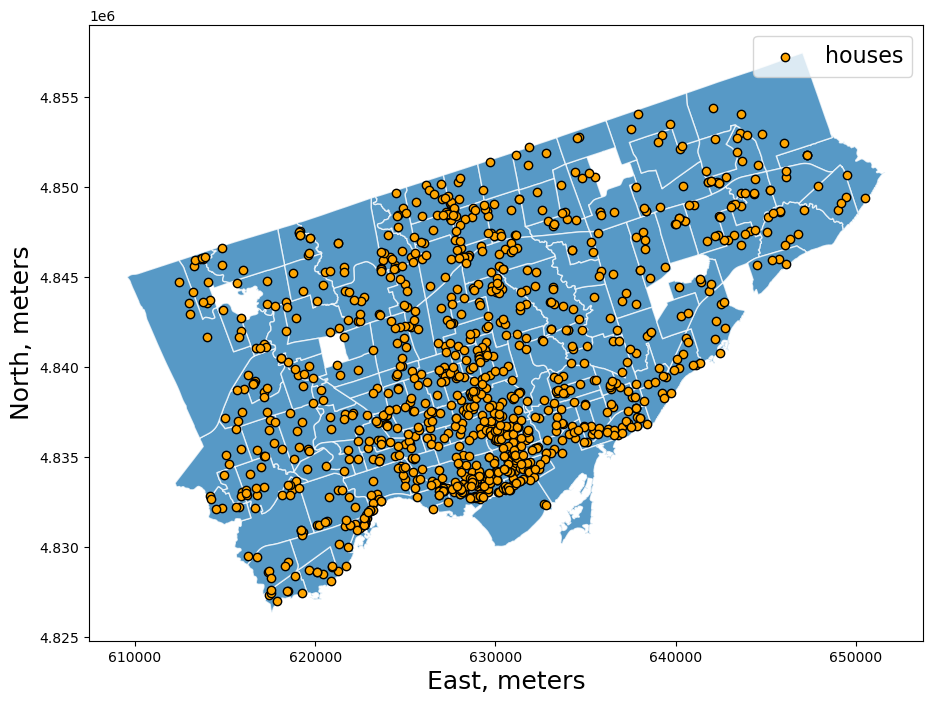

In [63]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
house_gdf.plot(ax=ax, color='orange', edgecolor='k', label='houses')
plt.legend(fontsize=16)
plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18);

In [65]:
from folium.plugins import HeatMap

In [67]:
# Create a map of Toronto
map_2 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron', 
                   zoom_start=10)

# Add points to the map
HeatMap(data=list(zip(house_gdf.to_crs(epsg=4326).geometry.y,
                      house_gdf.to_crs(epsg=4326).geometry.x)),
        radius=20).add_to(map_2)

# Display map
map_2

## Calculate the total facilities around each house

In [178]:
toronto_1500['Total Facilities 1500'] = toronto_1500[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

toronto_1000['Total Facilities 1000'] = toronto_1000[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

toronto_500['Total Facilities 500'] = toronto_500[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

toronto_500['street address'] = toronto_500['street address'].str.lower()
toronto_1000['street address'] = toronto_1000['street address'].str.lower()
toronto_1500['street address'] = toronto_1500['street address'].str.lower()


house_merged = house_merged.merge(toronto_500[['street address', 'Total Facilities 500']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_500m'))


house_merged = house_merged.merge(toronto_1000[['street address', 'Total Facilities 1000']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_1000m'))


house_merged = house_merged.merge(toronto_1500[['street address', 'Total Facilities 1500']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_1500m'))


house_merged.rename(columns={
    'Total Facilities_500m': 'Total Facilities within 500m',
    'Total Facilities_1000m': 'Total Facilities within 1000m',
    'Total Facilities_1500m': 'Total Facilities within 1500m'
}, inplace=True)


house_merged.to_csv('final_merged_toronto.csv')
